# Imports

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Tuple, Union, Sequence

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
from shared.enums import DatasetType, EvaluationLevel

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import PIL


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm
import json

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/urothel_ca')
PATH_WSIS = PATH/'Neue_Scans_Urothelkarzinome'
#PATH_ROIS = PATH/'Rois_Christoph'
PATH_ROIS = PATH/'Rois_Samir'
PATH_ROIS_ADJUSTED = PATH/'Rois_Samir_adjusted'
PATH_EXCEL_SHEET = PATH/'Data_Sheet_MIER_22112021.xlsx'


seed = 42
np.random.seed(seed)

# Data

In [3]:
wsi_mrxs_paths = [p for p in PATH_WSIS.ls() if p.suffix == '.mrxs']
len(wsi_mrxs_paths)

239

In [4]:
wsi_dir_paths = [p for p in PATH_WSIS.ls() if p.suffix == '']
len(wsi_dir_paths)

239

In [5]:
json_paths = PATH_ROIS.ls()
len(json_paths)

233

## rename files and directories

### json paths

In [45]:
p = json_paths[0]; p

Path('/home/Deep_Learner/private/datasets/urothel_ca/Rois_Christoph/MIER_3_D.json')

In [46]:
new_name = p.name.replace('%20', '_');new_name

'MIER_3_D.json'

In [47]:
new_p = p.parent/new_name; new_p

Path('/home/Deep_Learner/private/datasets/urothel_ca/Rois_Christoph/MIER_3_D.json')

In [48]:
p.replace(new_p)

In [49]:
for p in json_paths:
    new_name = p.name.replace('%20', '_')
    new_p = p.parent/new_name
    p.replace(new_p)

### mrxs files

In [11]:
for p in wsi_mrxs_paths:
    new_name = p.name.replace(' ', '_')
    new_p = p.parent/new_name
    p.replace(new_p)

### corresponding mrxs dirs

In [44]:
for p in wsi_dir_paths:
    new_name = p.name.replace(' ', '_')
    new_p = p.parent/new_name
    p.replace(new_p)

## get rois for each wsi path

### wsi path to json file mapping

In [6]:
def find_json_path(mrxs_path:pathlib.Path)->pathlib.Path:
    stem = mrxs_path.stem
    for jp in json_paths:
        if(jp.stem == stem):
            return jp
    return None

In [7]:
wsi_mrxs_to_json_path = {}
wsi_mrxs_paths_without_corresponding_json_file = []
for mrxs_p in wsi_mrxs_paths:
    jp = find_json_path(mrxs_path=mrxs_p)
    if(jp is not None):
        wsi_mrxs_to_json_path[mrxs_p] = jp
    else:
        wsi_mrxs_paths_without_corresponding_json_file.append(mrxs_p)

In [8]:
len(wsi_mrxs_to_json_path)

233

In [9]:
len(wsi_mrxs_paths_without_corresponding_json_file)

6

### custom function that creates PolygonHelper objects from a given json file with the roi coordinates

In [10]:
class __PolygonHelper:
    def __init__(self, level:int, vertices:Sequence[Tuple[float, float]]):
        self.level = level
        self.vertices = vertices

def get_polygons_from_json(json_path:pathlib.Path)->List[__PolygonHelper]:
    """
    Reads the json file and returns a list of __PolygonHelper objects. 
    This should be a specialized function for the specific structure of your json files.
    
    Arguments:
        json_path: path to json file
        
    Returns:
        List of __PolygonHelper objects
    """
    polygons = []
    with open(json_path) as json_file:
        for i, annotation in enumerate(json.load(json_file)):
            #some annotations do not have a "classification" prop
            # => just skip them
            try:
                annotation["properties"]["classification"]
            except KeyError as ke:
                print(ke)
                print(f'annotation num: {i}')
                continue
                
            #skip rois that are not classified as Tumor
            if(annotation["properties"]["classification"]["name"] == "Tumor"):
                if(annotation["geometry"]["type"] == 'MultiPolygon'):
                    multi_polygon_vertices = annotation["geometry"]["coordinates"]
                    #print(f'Multi Polygon: {np.array(multi_polygon_vertices).squeeze().shape}')
                    ##QuPath produces Polygons and Multipolygons 
                    ##(see difference here: https://gis.stackexchange.com/questions/225368/understanding-difference-between-polygon-and-
                    ##multipolygon-for-shapefiles-in-qgis/225373)
                    ##This loop separates Multipolygons into individual Polygons
                    for sub_polygon_vertices in multi_polygon_vertices:
                        sub_polygon_vertices_array = np.array(sub_polygon_vertices, dtype=object).squeeze()
                        if(len(sub_polygon_vertices_array.shape) == 2 and sub_polygon_vertices_array.shape[1] == 2):
                            #print(f'/1/: {sub_polygon_vertices_array.shape}')
                            polygons.append(__PolygonHelper(level=0, vertices=sub_polygon_vertices_array))
                        else:
                            for elem in sub_polygon_vertices_array:
                                elem_array = np.array(elem).squeeze()
                                #print(f'/2/: {elem_array.shape}')
                                polygons.append(__PolygonHelper(level=0, vertices=elem_array))
                    
                elif(annotation["geometry"]["type"] == 'Polygon'):
                    vertices = annotation["geometry"]["coordinates"]
                    #print(f'/3/ len of vertices: {len(vertices)}')
                    for ls in vertices:               
                        #print(f'/4/: {np.array(ls).squeeze().shape}')
                        polygons.append(__PolygonHelper(level=0, vertices=np.array(ls, dtype=object).squeeze()))
                else:
                    assert False
    return polygons

### adjust misalligned rois because of black and white padding when mrxs files are opened by openslide

In [11]:
def is_row_black(img:Union[PIL.Image.Image, numpy.ndarray], row_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[row_num, :, :] == [0,0,0])

def is_column_black(img:Union[PIL.Image.Image, numpy.ndarray], column_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[:, column_num, :] == [0,0,0])

def get_num_of_black_rows_at_top(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_rows = 0
    while(is_row_black(img=img, row_num=n_rows)):
        n_rows += 1
    return n_rows

def get_num_of_black_columns_at_left(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_columns = 0
    while(is_column_black(img=img, column_num=n_columns)):
        n_columns += 1
    return n_columns

class Row_or_col(Enum):
    ROW = 1
    COLUMN = 2
    
def is_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], index:int, row_or_col:Row_or_col)->bool:
    """
    checks if the by index specified row or column in the image contains only [0,0,0] == black
    or [255,255,255] == white RGB values
    """
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    a = None
    if(row_or_col is Row_or_col.ROW):
        a = img[index, :, :]
    elif(row_or_col is Row_or_col.COLUMN):
        a = img[:, index, :]
    else:
        raise ValueError('row_or_col has insufficient value')
    return np.where(np.logical_and(np.ravel(a) > 0, np.ravel(a) < 255))[0].size == 0

def get_num_of_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], row_or_col:Row_or_col)->int:
    n = 0
    while(is_only_black_white(img=img, index=n, row_or_col=row_or_col)):
        n += 1
    return n

def adjust_rois(wsi_img:Union[PIL.Image.Image, numpy.ndarray], 
                wsi_img_level:int, 
                rois:List[roi.RegionOfInterestPolygon]):
    """
    returns new RegionOfInterestPolygon objects
    """
    cols_left = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.COLUMN)
    rows_top = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.ROW)
    rois_adjusted = []
    for r in rois:
        new_vertices = util.polygon_to_numpy(r.polygon)
        new_vertices += [util.adjust_level(value_to_adjust=cols_left, from_level=wsi_img_level, to_level=r.level), 
                         util.adjust_level(value_to_adjust=rows_top, from_level=wsi_img_level, to_level=r.level)]
        r_new = roi.RegionOfInterestPolygon(roi_id=r.roi_id, vertices=new_vertices, level=r.level)
        rois_adjusted.append(r_new)

    return rois_adjusted

def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def adjust_and_save_rois(wsi_path, json_path):
    print(f'wsi: {wsi_path.name}')
    print(f'json: {json_path.name}')
        
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    if(not save_path.exists()):    
        wh = tiles.WsiHandler(wsi_path=wsi_path)
        rois = roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path, 
                                        polygons_from_json_func=get_polygons_from_json)       
        rois_adjusted = adjust_rois(wsi_img=wh.get_wsi_as_pil_image(level=5), wsi_img_level=5, rois=rois)               
        save_as_pickle(rois_adjusted, save_path)
    else:
        print(f'Already exists: {save_path}')    

In [14]:
failed = []
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    try:
        adjust_and_save_rois(wsi_path, json_path)
    except:
        failed.append(wsi_path)

100%|██████████| 233/233 [00:00<00:00, 1713.46it/s]

wsi: MIER_140_M17.mrxs
json: MIER_140_M17.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_140_M17-rois_adjusted.pickle
wsi: MIER_151_M3.mrxs
json: MIER_151_M3.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_151_M3-rois_adjusted.pickle
wsi: MIER_158_TUR2.mrxs
json: MIER_158_TUR2.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_158_TUR2-rois_adjusted.pickle
wsi: MIER_175_M12.mrxs
json: MIER_175_M12.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_175_M12-rois_adjusted.pickle
wsi: MIER_200_M9.mrxs
json: MIER_200_M9.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_200_M9-rois_adjusted.pickle
wsi: MIER_211_C.mrxs
json: MIER_211_C.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_211_C-rois_adjusted.pickle
wsi: MIER_217_C.mrxs
json

  0%|          | 0/20 [00:00<?, ?it/s]

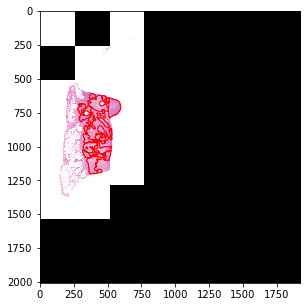

  5%|▌         | 1/20 [00:08<02:41,  8.51s/it]

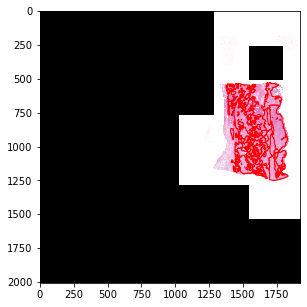

 10%|█         | 2/20 [00:27<03:27, 11.51s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-c62c7fc30925>", line 4, in <module>
    rois = load_pickle(save_path)
  File "<ipython-input-12-dbd23acc2064>", line 73, in load_pickle
    return pickle.load(file)
  File "/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/shapely/geometry/base.py", line 250, in __setstate__
    def __setstate__(self, state):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most rece

KeyboardInterrupt: 

In [14]:
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:20]):
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    rois = load_pickle(save_path)
    util.show_wsi_with_rois(wsi_path=wsi_path, rois=rois, figsize=(5,5), scale_factor=128)

In [15]:
#no stroma rois
wsi_path_to_rois = {}
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    rois = load_pickle(save_path)
    wsi_path_to_rois[wsi_path] = rois

100%|██████████| 233/233 [00:14<00:00, 16.54it/s]


## playground

In [19]:
data_sheet = pd.read_excel(PATH_EXCEL_SHEET, engine='openpyxl')

In [20]:
data_sheet

,TMA_Nr,Survival Time (months),OS_Censor,DSS_Censor,Recurrence Free Survival (months),RFS_Censor,1°/2°-MIBC,Initial pT-Stage,pT-Stage Summary,pN-Stage,...,Adjuvant chemotherapy,Histology,Variant Histology,%_Variant Histology,Variant Summary,FGFR3_Mutation,FGFR3_Fusion,FGFR3_Summary,Meta_Immune Phenotypes,Consensus Cluster
0,1,88.07,0,0,79.53,0,Primary,pT2,pT4,pN0,...,No,Urothelial,NOS,NaN,Urothelial - NOS,WT,WT,WT,Uninflamed,NaN
1,2,5.00,0,1,5.00,1,Primary,pT2,pT2,pN0,...,No,Urothelial,Lymphoepithelioma-like,NaN,Urothelial - Variant Histology,WT,WT,WT,Evasion Phenotype,Ba/Sq
2,3,129.47,0,1,129.47,1,Primary,pT2,pT3,pN0,...,No,Urothelial,Squamous,0.6,Urothelial - Squamous,WT,WT,WT,Inflamed: High,LumU
3,4,6.63,0,0,6.63,0,Primary,pT2,pT3,pN2,...,No,Neuroendocrine,Neuroendocrine,NaN,Neuroendocrine,WT,WT,WT,Uninflamed,NE-like
4,5,27.77,0,0,16.37,0,Secondary,"pT1/ pTa, CIS",pT3,pNX,...,Yes,Urothelial,Squamous,0.4,Urothelial - Squamous,WT,WT,WT,Uninflamed,Ba/Sq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,243,14.47,1,1,7.47,0,Primary,pT2,pT2,pN2,...,Yes,Urothelial,NOS,NaN,Urothelial - NOS,G372C,WT,Altered,Inflamed: Low,LumP
243,244,14.70,1,1,12.40,0,Primary,pT2,pT2,pN0,...,No,Urothelial,Neuroendocrine,0.9,Urothelial - Variant Histology,WT,WT,WT,Inflamed: Low,NE-like
244,245,4.73,1,1,4.73,1,Primary,pT2,pT2,pNX,...,No,Urothelial,NOS,NaN,Urothelial - NOS,WT,WT,WT,Inflamed: Low,LumNS
245,246,4.50,0,0,3.27,0,Primary,pT2,pT3,pN0,...,No,Urothelial,Squamous,0.3,Urothelial - Squamous,WT,WT,WT,Uninflamed,Ba/Sq


In [25]:
s = 'MIER_140_M17'

In [28]:
s.split('_')

['MIER', '140', 'M17']

In [41]:
stems = []
tma_nrs = []
for wsi_path in list(wsi_path_to_rois.keys()):
    stem = wsi_path.stem
    stems.append(stem)
    split = stem.split('_')
    tma_nr = split[1]
    tma_nrs.append(tma_nr)

In [88]:
tma_nr = 247

In [61]:
data_sheet.iloc[0]['Histology']

'Urothelial'

In [63]:
data_sheet.iloc[0]['Variant Histology']

'NOS'

In [76]:
data_sheet.max()['TMA_Nr']

247

In [78]:
len(data_sheet.index)

247

In [91]:
histos = []
v_histos = []

for i in range(len(data_sheet.index)):
    row = data_sheet.iloc[i]
    histology = row['Histology']
    variant_histology = row['Variant Histology']
    
    histos.append(histology)
    v_histos.append(variant_histology)

In [85]:
set(histos)

{'Neuroendocrine', 'Urothelial'}

In [87]:
set(v_histos)

{'Glandular',
 'Glycogen rich',
 'LNUC',
 'Lymphoepithelioma-like',
 'MPUC',
 'NOS',
 'NUC',
 'Neuroendocrine',
 'PUC',
 'Sarcomatoid',
 'Squamous',
 'Trophoblastoid'}

## id and label funcs

In [17]:
data_sheet = pd.read_excel(PATH_EXCEL_SHEET, engine='openpyxl')

# one case per patient => patient id == case id
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return get_case_id_from_wsi_path(wsi_path=wsi_path)
    
def get_case_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    split = wsi_path.stem.split('_')
    return f'{split[0]}_{split[1]}'    

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return wsi_path.stem

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None)->List[int]:
    tma_nr = wsi_path.stem.split('_')[1]
    row = data_sheet.iloc[int(tma_nr)-1]
    histology = row['Histology']
    variant_histology = row['Variant Histology']
    return [histology, variant_histology]

## tiles

In [ ]:
tilesummaries = tiles.WsisToTilesParallel(wsi_paths=list(wsi_path_to_rois.keys()),
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          tile_scoring_function=tiles.score_tile_1,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois,
                                          minimal_tile_roi_intersection_ratio=0.95, 
                                          verbose=True, 
                                          grids_per_roi=3, 
                                          optimize_grid_angles=True)


  0%|          | 0/233 [00:00<?, ?it/s]

Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_140_M17.mrxs
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_151_M3.mrxs
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_200_M9.mrxs
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_175_M12.mrxs
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_211_C.mrxs
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_217_C.mrxs
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_40_D.mrxs
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_158_TUR2.mrxs
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_236_

In [ ]:
#tilesummaries = []
#failed_wsi_paths = {}

In [398]:
for wsi_path in tqdm(list(wsi_path_to_rois.keys())):
#for wsi_path in tqdm(list(failed_wsi_paths.keys())[:]):
    rois = wsi_path_to_rois[wsi_path]
    try:
        ts = tiles.WsiToTiles(wsi_path=wsi_path,
                              tile_height=1024, 
                                              tile_width=1024, 
                                              tile_scoring_function=tiles.score_tile_1,
                                              tile_score_thresh=0.2, 
                                              level=0, 
                                              rois=rois,
                                              minimal_tile_roi_intersection_ratio=0.95, 
                                              verbose=True, 
                                              grids_per_roi=1)
        tilesummaries.append(ts)
        try:
            del failed_wsi_paths[wsi_path]
        except:
            pass
    except Exception as e:
        failed_wsi_paths[wsi_path] = e




  0%|          | 0/233 [00:00<?, ?it/s]

Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_140_M17.mrxs
733
IndexError in WsiToTiles for the rectangle: (ul: (x:65544.0, y:128678.0), ur: (x:66568.0, y:128678.0), lr: (x:66568.0, y:129702.0), ll: (x:65544.0, y:129702.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:40780.0, y:128053.0), ur: (x:41804.0, y:128053.0), lr: (x:41804.0, y:129077.0), ll: (x:40780.0, y:129077.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:64912.0, y:91172.0), ur: (x:65936.0, y:91172.0), lr: (x:65936.0, y:92196.0), ll: (x:64912.0, y:92196.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:64912.0, y:92196.0), ur: (x:65936.0, y:92196.0), lr: (x:65936.0, y:93220.0), ll: (x:64912.0, y:93220.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:61459.0, y:114174.0), ur: (x:62483.0, y:114174.0), lr: (x:62483.0, y:115198.0), ll: (x:61459.0, y:115198.0))





  0%|          | 1/233 [00:45<2:56:17, 45.59s/it]

/home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_140_M17.mrxs: Number of tiles that will be kept/all possible tiles:             699/728
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_151_M3.mrxs
1589
IndexError in WsiToTiles for the rectangle: (ul: (x:224685.0, y:144926.0), ur: (x:225709.0, y:144926.0), lr: (x:225709.0, y:145950.0), ll: (x:224685.0, y:145950.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:197712.74, y:138311.0), ur: (x:198736.74, y:138311.0), lr: (x:198736.74, y:139335.0), ll: (x:197712.74, y:139335.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:201623.0, y:84653.0), ur: (x:202647.0, y:84653.0), lr: (x:202647.0, y:85677.0), ll: (x:201623.0, y:85677.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:189429.0, y:121670.0), ur: (x:190453.0, y:121670.0), lr: (x:190453.0, y:122694.0), ll: (x:189429.0, y:122694.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:196




  1%|          | 2/233 [05:22<7:22:24, 114.91s/it]

/home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_151_M3.mrxs: Number of tiles that will be kept/all possible tiles:             1150/1582
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_158_TUR2.mrxs
192
IndexError in WsiToTiles for the rectangle: (ul: (x:51488.0, y:157744.02), ur: (x:52512.0, y:157744.02), lr: (x:52512.0, y:158768.02), ll: (x:51488.0, y:158768.02))





  1%|▏         | 3/233 [07:13<7:16:25, 113.85s/it]

/home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_158_TUR2.mrxs: Number of tiles that will be kept/all possible tiles:             191/191
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_175_M12.mrxs
629





  2%|▏         | 4/233 [08:35<6:38:09, 104.32s/it]

/home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_175_M12.mrxs: Number of tiles that will be kept/all possible tiles:             48/629
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_200_M9.mrxs
506
IndexError in WsiToTiles for the rectangle: (ul: (x:52398.0, y:93582.0), ur: (x:53422.0, y:93582.0), lr: (x:53422.0, y:94606.0), ll: (x:52398.0, y:94606.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:34183.0, y:55559.0), ur: (x:35207.0, y:55559.0), lr: (x:35207.0, y:56583.0), ll: (x:34183.0, y:56583.0))





  2%|▏         | 5/233 [08:49<4:52:51, 77.07s/it] 

/home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_200_M9.mrxs: Number of tiles that will be kept/all possible tiles:             495/504
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_211_C.mrxs
822
IndexError in WsiToTiles for the rectangle: (ul: (x:244428.0, y:79222.0), ur: (x:245452.0, y:79222.0), lr: (x:245452.0, y:80246.0), ll: (x:244428.0, y:80246.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:222317.0, y:105679.0), ur: (x:223341.0, y:105679.0), lr: (x:223341.0, y:106703.0), ll: (x:222317.0, y:106703.0))





  3%|▎         | 6/233 [09:50<4:34:09, 72.47s/it]

/home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_211_C.mrxs: Number of tiles that will be kept/all possible tiles:             788/820
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_217_C.mrxs
207





  3%|▎         | 7/233 [10:20<3:44:32, 59.61s/it]

/home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_217_C.mrxs: Number of tiles that will be kept/all possible tiles:             207/207
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_236_C.mrxs
440
IndexError in WsiToTiles for the rectangle: (ul: (x:225724.31, y:134618.0), ur: (x:226748.31, y:134618.0), lr: (x:226748.31, y:135642.0), ll: (x:225724.31, y:135642.0))





  3%|▎         | 8/233 [11:58<4:27:08, 71.24s/it]

/home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_236_C.mrxs: Number of tiles that will be kept/all possible tiles:             438/439
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_40_D.mrxs
2861
IndexError in WsiToTiles for the rectangle: (ul: (x:29088.0, y:86287.0), ur: (x:30112.0, y:86287.0), lr: (x:30112.0, y:87311.0), ll: (x:29088.0, y:87311.0))
IndexError in WsiToTiles for the rectangle: (ul: (x:82336.0, y:123151.0), ur: (x:83360.0, y:123151.0), lr: (x:83360.0, y:124175.0), ll: (x:82336.0, y:124175.0))





  4%|▍         | 9/233 [15:27<6:59:40, 112.41s/it]

/home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_40_D.mrxs: Number of tiles that will be kept/all possible tiles:             2839/2859
Starting to process /home/Deep_Learner/private/datasets/urothel_ca/Neue_Scans_Urothelkarzinome/MIER_52_B.mrxs
1769


KeyboardInterrupt: 

In [ ]:
len(tilesummaries)

In [ ]:
len(failed_wsi_paths)

## patient manager

In [416]:
patient_manager = PatientManager()

patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, 
                                          case_id_getter=get_case_id_from_wsi_path, 
                                          slide_id_getter=get_slide_id_from_wsi_path, 
                                          labels_getter=get_labels_from_wsi_path)






  0%|          | 0/233 [00:00<?, ?it/s]




  3%|▎         | 6/233 [00:00<00:03, 57.93it/s]




  3%|▎         | 8/233 [00:00<00:07, 30.79it/s]




  5%|▌         | 12/233 [00:00<00:07, 28.70it/s]




  6%|▋         | 15/233 [00:00<00:13, 16.68it/s]




  8%|▊         | 18/233 [00:00<00:12, 17.36it/s]




 10%|▉         | 23/233 [00:01<00:10, 19.18it/s]




 11%|█         | 25/233 [00:01<00:11, 17.83it/s]




 12%|█▏        | 28/233 [00:01<00:12, 15.90it/s]




 13%|█▎        | 30/233 [00:01<00:15, 13.05it/s]




 14%|█▎        | 32/233 [00:01<00:14, 14.13it/s]




 15%|█▍        | 34/233 [00:02<00:24,  8.01it/s]




 15%|█▌        | 36/233 [00:02<00:23,  8.35it/s]




 17%|█▋        | 39/233 [00:02<00:18, 10.59it/s]




 18%|█▊        | 43/233 [00:02<00:14, 13.15it/s]




 20%|█▉        | 46/233 [00:02<00:13, 13.65it/s]




 21%|██        | 49/233 [00:03<00:11, 15.37it/s]




 22%|██▏       | 51/233 [00:03<00:12, 14.46it/s]




 23%|██▎       | 53/233 [00:03<00:12, 13.97it/s]





In [418]:
class_distribution_all_tiles = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)
class_distribution_all_tiles

(198506,
 {'Glandular': 1563,
  'Glycogen rich': 1037,
  'LNUC': 7195,
  'Lymphoepithelioma-like': 750,
  'MPUC': 15563,
  'NOS': 80000,
  'NUC': 2210,
  'Neuroendocrine': 14357,
  'PUC': 6899,
  'Sarcomatoid': 23185,
  'Squamous': 51130,
  'Trophoblastoid': 804,
  'Urothelial': 192319},
 {'Glandular': 0.007873817416098255,
  'Glycogen rich': 0.005224023455210422,
  'LNUC': 0.03624575579579459,
  'Lymphoepithelioma-like': 0.003778223328262118,
  'MPUC': 0.07840065287699112,
  'NOS': 0.4030104883479593,
  'NUC': 0.011133164740612374,
  'Neuroendocrine': 0.07232526976514564,
  'PUC': 0.03475461698890714,
  'Sarcomatoid': 0.11679747715434294,
  'Squamous': 0.2575740783653895,
  'Trophoblastoid': 0.0040502554078969905,
  'Urothelial': 0.9688321763573897})

In [419]:
class_distribution_all_slides = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.slide, 
                                                            dataset_type=shared.enums.DatasetType.all)
class_distribution_all_slides

(232,
 {'Glandular': 4,
  'Glycogen rich': 2,
  'LNUC': 7,
  'Lymphoepithelioma-like': 3,
  'MPUC': 12,
  'NOS': 96,
  'NUC': 5,
  'Neuroendocrine': 10,
  'PUC': 11,
  'Sarcomatoid': 21,
  'Squamous': 60,
  'Trophoblastoid': 1,
  'Urothelial': 225},
 {'Glandular': 0.017241379310344827,
  'Glycogen rich': 0.008620689655172414,
  'LNUC': 0.03017241379310345,
  'Lymphoepithelioma-like': 0.01293103448275862,
  'MPUC': 0.05172413793103448,
  'NOS': 0.41379310344827586,
  'NUC': 0.021551724137931036,
  'Neuroendocrine': 0.04310344827586207,
  'PUC': 0.04741379310344827,
  'Sarcomatoid': 0.09051724137931035,
  'Squamous': 0.25862068965517243,
  'Trophoblastoid': 0.004310344827586207,
  'Urothelial': 0.9698275862068966})

In [420]:
patient_manager.undersample(dataset_type=DatasetType.all, delta=0.1, verbose=True, minimum_number_of_tiles=750)

{'Glandular': 0.007873817416098255, 'Glycogen rich': 0.005224023455210422, 'LNUC': 0.03624575579579459, 'Lymphoepithelioma-like': 0.003778223328262118, 'MPUC': 0.07840065287699112, 'NOS': 0.4030104883479593, 'NUC': 0.011133164740612374, 'Neuroendocrine': 0.07232526976514564, 'PUC': 0.03475461698890714, 'Sarcomatoid': 0.11679747715434294, 'Squamous': 0.2575740783653895, 'Trophoblastoid': 0.0040502554078969905, 'Urothelial': 0.9688321763573897}







100%|██████████| 6385/6385 [00:00<00:00, 557221.68it/s]

n to remove: 6385








100%|██████████| 6172/6172 [00:00<00:00, 535214.28it/s]

n to remove: 6172








100%|██████████| 5967/5967 [00:00<00:00, 561102.41it/s]

n to remove: 5967


{'Glandular': 0.00782300452267449, 'Glycogen rich': 0.005761687279839095, 'LNUC': 0.03581469258036915, 'Lymphoepithelioma-like': 0.004167083375004167, 'MPUC': 0.07737996021824405, 'NOS': 0.4003678145592337, 'NUC': 0.011467813448011469, 'Neuroendocrine': 0.0787689880099121, 'PUC': 0.034308986454200975, 'Sarcomatoid': 0.1155560000444489, 'Squamous': 0.2588314386994255, 'Trophoblastoid': 0.004128190596837462, 'Urothelial': 0.965624340211799}







100%|██████████| 5768/5768 [00:00<00:00, 573546.04it/s]

n to remove: 5768








100%|██████████| 5576/5576 [00:00<00:00, 573784.08it/s]

n to remove: 5576








100%|██████████| 5390/5390 [00:00<00:00, 572815.23it/s]

n to remove: 5390


{'Glandular': 0.007663187297853573, 'Glycogen rich': 0.006352298343624424, 'LNUC': 0.03462829559933353, 'Lymphoepithelioma-like': 0.004594236989120847, 'MPUC': 0.075590512594335, 'NOS': 0.39759752033715573, 'NUC': 0.011657110653729295, 'Neuroendocrine': 0.08600411643634225, 'PUC': 0.034922326766637264, 'Sarcomatoid': 0.11377168479858865, 'Squamous': 0.26056674507497796, 'Trophoblastoid': 0.004551357443889052, 'Urothelial': 0.9621006076644124}







100%|██████████| 5210/5210 [00:00<00:00, 565126.82it/s]

n to remove: 5210








100%|██████████| 5036/5036 [00:00<00:00, 584673.93it/s]

n to remove: 5036








100%|██████████| 4869/4869 [00:00<00:00, 559723.35it/s]

n to remove: 4869


{'Glandular': 0.007419008593628699, 'Glycogen rich': 0.0070004657976278075, 'LNUC': 0.03353067851187784, 'Lymphoepithelioma-like': 0.005063017693559166, 'MPUC': 0.07254291751331574, 'NOS': 0.3968730802724579, 'NUC': 0.011881214854218844, 'Neuroendocrine': 0.09383459458729655, 'PUC': 0.035299359359494506, 'Sarcomatoid': 0.1108328326571392, 'Squamous': 0.26247358792436526, 'Trophoblastoid': 0.005015762861752615, 'Urothelial': 0.9582334793732659}







100%|██████████| 4706/4706 [00:00<00:00, 559272.22it/s]

n to remove: 4706








100%|██████████| 4549/4549 [00:00<00:00, 578266.07it/s]

n to remove: 4549








100%|██████████| 4398/4398 [00:00<00:00, 581634.84it/s]

n to remove: 4398


{'Glandular': 0.007346817370612731, 'Glycogen rich': 0.007711183819155264, 'LNUC': 0.033030933967876264, 'Lymphoepithelioma-like': 0.0055770374776918505, 'MPUC': 0.06838935157644259, 'NOS': 0.3948319452706722, 'NUC': 0.012291790600832837, 'Neuroendocrine': 0.10302647233789411, 'PUC': 0.03709845330160619, 'Sarcomatoid': 0.10805324211778704, 'Squamous': 0.2631246281975015, 'Trophoblastoid': 0.005524985127900059, 'Urothelial': 0.9539931588340274}







100%|██████████| 4251/4251 [00:00<00:00, 543249.33it/s]

n to remove: 4251








100%|██████████| 4109/4109 [00:00<00:00, 574920.61it/s]

n to remove: 4109








100%|██████████| 3973/3973 [00:00<00:00, 581964.44it/s]

n to remove: 3973


{'Glandular': 0.00808861453822034, 'Glycogen rich': 0.008489770522403333, 'LNUC': 0.03124104562535306, 'Lymphoepithelioma-like': 0.006140142615045805, 'MPUC': 0.06140142615045806, 'NOS': 0.39069318116695456, 'NUC': 0.013532874323560956, 'Neuroendocrine': 0.11342890124194618, 'PUC': 0.04033664355244091, 'Sarcomatoid': 0.1085249740067296, 'Squamous': 0.2626916747852997, 'Trophoblastoid': 0.006082834617305378, 'Urothelial': 0.9493479168542821}







100%|██████████| 3840/3840 [00:00<00:00, 572275.70it/s]

n to remove: 3840








100%|██████████| 3712/3712 [00:00<00:00, 575573.25it/s]

n to remove: 3712








100%|██████████| 3588/3588 [00:00<00:00, 598114.65it/s]

n to remove: 3588


{'Glandular': 0.008900339618222274, 'Glycogen rich': 0.009341753222769734, 'LNUC': 0.030989036727413585, 'Lymphoepithelioma-like': 0.006756330681848892, 'MPUC': 0.06395993045483618, 'NOS': 0.3865972416153936, 'NUC': 0.01489095282279496, 'Neuroendocrine': 0.12481194879602188, 'PUC': 0.044384588359292654, 'Sarcomatoid': 0.10579513003684453, 'Squamous': 0.25261469997387553, 'Trophoblastoid': 0.006693271595484969, 'Urothelial': 0.9442647760952012}
Could not reach the desired delta of 0.1.                            Only reached a delta of 0.9375715044997163                            Try a smaller <minimum_number_of_tiles>.


In [ ]:
class_distribution_all_tiles = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)
class_distribution_all_tiles

[autoreload of torch failed: Traceback (most recent call last):
  File "/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/conda/envs/DLM_Py3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/envs/DLM_Py3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/torch/__init__.py", line 196, in <module>
    __all__ += [name for name in dir(_C)
NameError: name '_C' is not defined
]


In [ ]:
train_size = 0.8
validation_size = 0.1
test_size = 0.1

patient_manager.split(train_size=train_size, validation_size=validation_size, test_size=test_size, random_state=seed)